In [ ]:
# This notebook contains code to generate some extra diagrams, and to run EPSO properly.

In [1]:
# This code is Performs EPSO on a Discrete Graph
import pickle
import numpy as np
import random

# Loading the database
X = pickle.load(open('input_output.pkl', 'rb'))['x']
print("shape of X:", np.shape(X))

y = pickle.load(open('input_output.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

# A function to return the index of the input in the database
def input_index(Xinput):
  for i, input in enumerate(X):
    if np.array_equal(Xinput, input):
      return y[i]
  return None

shape of X: (25877, 151)
shape of y: (25877,)


In [2]:
# Evolutionary PSO code:

def objective_function(x):
    x = np.array(x)

    # Finding the closest data point in the dataset
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    return y[closest_index]

# snap_position essentially snaps the input to the point in the database closest to it
def snap_position(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    snapped_input = X[closest_index]
    return snapped_input

# returns the index in the database closest to the input given to the method
def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

# See Evolutionary_Graph_PSO for the working of EPSO
class Particle:
    def __init__(self, num_dimensions, init_position, index):
        self.position = init_position
        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = objective_function(self.position)
        self.index = index
        # This array is keeps track of all of the inputs in the database that the particle has visited. useful for generating plots later
        self.positions_traversed = [closest_index(init_position)]

class PSO:
    def __init__(self, num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, init_positions):
        self.num_particles = num_particles
        self.num_dimensions = num_dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.num_iterations = num_iterations
        self.particles = [Particle(num_dimensions, init_positions[ind], ind) for ind in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].position)
        self.global_best_fitness = self.particles[0].best_fitness
        # These arrays are used to generate some useful information used to plot graphs later
        self.unique_function_call_ids = []
        self.global_max_for_each_unique_function_call = []

        init_pos_max = -1.0
        init_position_max = np.copy(self.particles[0].position)
        for init_pos in init_positions:
            self.unique_function_call_ids.append(closest_index(init_pos))
            if (y[closest_index(init_pos)] > init_pos_max):
                init_position_max = np.copy(init_pos)
                init_pos_max = y[closest_index(init_pos)]
            self.global_max_for_each_unique_function_call.append(init_pos_max)

        self.global_best_position = np.copy(init_position_max)
        self.global_best_fitness = init_pos_max

    def update_particles(self):
        for particle in self.particles:
            particle.velocity = (self.w * particle.velocity
                                 + self.c1 * np.random.rand() * (particle.best_position - particle.position)
                                 + self.c2 * np.random.rand() * (self.global_best_position - particle.position))

            if(np.linalg.norm(particle.velocity) > 1.5):
                particle.velocity = (particle.velocity / np.linalg.norm(particle.velocity)) * 1.5

            particle.position = particle.position + particle.velocity

            particle.position = np.clip(particle.position, self.lower_bound, self.upper_bound)
            particle.position = snap_position(particle.position)

            particle.positions_traversed.append(closest_index(particle.position))


    def update_personal_and_global_bests(self):
        for particle in self.particles:
            unique_function_called = False
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
                unique_function_called = True

            current_fitness = objective_function(particle.position)

            if current_fitness > particle.best_fitness:
                particle.best_position = np.copy(particle.position)
                particle.best_fitness = current_fitness

                if current_fitness > self.global_best_fitness:
                    self.global_best_position = np.copy(particle.position)
                    self.global_best_fitness = current_fitness

            if (unique_function_called == True):
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

    def eliminate(self):
        num_to_eliminate = int((self.num_particles / (self.num_iterations - 1)))
        if not self.particles:
            return []

        for _ in range(num_to_eliminate):
            min_index = 0
            for j in range(1, len(self.particles)):
                if (input_index(snap_position(self.particles[j].position)) < input_index(snap_position(self.particles[min_index].position))):
                    min_index = j
            self.particles.pop(min_index)

    def optimize(self):
        all_positions_traversed = []
        for i in range(self.num_particles):
            all_positions_traversed.append([0.0])

        for particle in self.particles:
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
            if particle.best_fitness > self.global_best_fitness:
                self.global_best_position = np.copy(particle.position)
                self.global_best_fitness = particle.best_fitness
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

        for i in range(self.num_iterations):
            self.update_particles()
            self.update_personal_and_global_bests()
            for j in range(self.num_particles):
                for k in self.particles:
                    if(j == k.index):
                        all_positions_traversed[j] = k.positions_traversed


            if (i != (self.num_iterations - 1)):
                self.eliminate()

        return self.global_best_position, self.global_best_fitness, all_positions_traversed, self.unique_function_call_ids, self.global_max_for_each_unique_function_call


In [3]:
# Running EPSO once
num_particles = 20
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w = 2.0
c1 = 1.0
c2 = 1.0
num_iterations = 10


initial_positions_PSO = random.choices(X, k=num_particles)
print(initial_positions_PSO)

pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions: ", all_positions)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)

[array([1.00000000e+00, 3.52109730e-03, 0.00000000e+00, 1.16681354e-01,
       3.28971944e-02, 2.18576570e-03, 3.33333333e-01, 3.38531694e-01,
       3.04821403e-01, 2.92068249e-01, 2.88763485e-01, 2.86473129e-01,
       3.50537634e-01, 8.17204301e-01, 5.06966292e-01, 9.56989247e-01,
       1.39784946e-01, 1.98924731e-01, 5.42000000e-01, 6.39175258e-01,
       3.84000000e-01, 7.62376238e-01, 1.50000000e-01, 6.40000000e-01,
       3.23504768e-01, 8.39338372e-01, 5.22909846e-01, 9.50772301e-01,
       1.11433929e-01, 1.66687885e-01, 4.39221421e-01, 1.32318541e-01,
       7.13337933e-02, 5.27433782e-01, 3.95115241e-01, 4.17168331e-01,
       4.70588235e-01, 6.47058824e-01, 5.00000000e-01, 7.64705882e-01,
       1.17647059e-01, 5.58823529e-01, 5.33333333e-01, 6.66666667e-01,
       4.20000000e-01, 1.00000000e+00, 3.33333333e-01, 4.16666667e-01,
       5.17370892e-01, 4.46009390e-01, 2.43380282e-01, 8.21596244e-01,
       3.75586854e-01, 4.41314554e-01, 2.66457680e-01, 1.88087774e-01,
     

Best position found:  [1.00000000e+00 3.23889640e-03 3.32881750e-02 1.63009600e-01
 2.52549741e-04 2.29561745e-03 5.00000000e-01 3.82074140e-01
 4.01972985e-01 4.37986659e-01 4.53905319e-01 4.64707288e-01
 2.93906810e-01 4.94623656e-01 3.38148743e-01 6.55913978e-01
 1.61290323e-01 1.61290323e-01 7.50952381e-01 6.70103093e-01
 3.57846999e-01 8.61386139e-01 2.20000000e-01 8.70000000e-01
 2.57932668e-01 4.86826607e-01 3.31355023e-01 6.14637614e-01
 1.27811007e-01 1.27811007e-01 1.90379552e-01 2.96834594e-01
 2.12790531e-01 3.95115241e-01 9.82806466e-02 9.82806466e-02
 7.22689076e-01 7.64705882e-01 4.69387755e-01 8.82352941e-01
 1.17647059e-01 8.82352941e-01 4.68253968e-01 5.00000000e-01
 3.46938775e-01 8.33333333e-01 3.33333333e-01 3.33333333e-01
 4.42208808e-01 4.36619718e-01 2.16665070e-01 7.84037559e-01
 3.47417840e-01 3.47417840e-01 4.41259890e-01 4.42006270e-01
 2.73985456e-01 5.61128527e-01 1.19122257e-01 5.61128527e-01
 1.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1

In [4]:
!pip install SciencePlots


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
# now, with this information, we'll try to see how it looks like on a graph: (there's a lot of copied code from Visualizations.ipynb)
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
from sklearn.decomposition import PCA
import scienceplots

plt.matplotlib.style.use(['science','nature'])
cool_colors = ['#0A84A4', '#F6C95E', '#6F4E7C', '#9DD967', '#CB472E', '#FFA157', '#8CDCD0']

plt.rcParams.update(plt.rcParamsDefault)

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[3], 'RF (div)': cool_colors[5]}

In [6]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

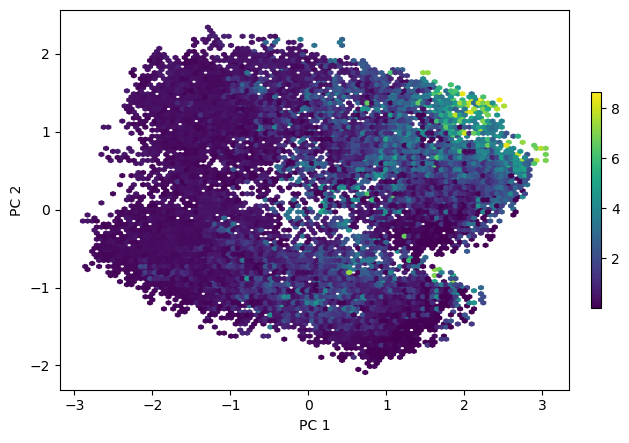

In [7]:
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
#plt.savefig('feature_space_colored_by_DC.pdf')
plt.show()

[[1863, 1863, 1863, 1863, 1863, 1863], [15133, 15133, 21035, 21035, 21035, 21035, 21035, 23023, 23023], [17013, 21009], [22634, 22634, 22387, 20758], [9184, 9184, 9184, 9184, 9184, 9184, 9184], [14447, 14447, 14555, 19119, 21035, 21035, 21775], [6618, 6464, 6464, 6464, 6464], [20103, 19106, 21035, 21035, 21035, 21775, 21775, 21775], [353, 12728, 12728, 16200, 23023, 23023, 23023, 23023, 23023], [16974, 16974, 16974], [644, 17866, 21035, 21035, 21035, 21035, 21035, 21035, 23023, 23023], [808, 808, 808, 808, 808, 808], [21035, 21035, 21035, 21035, 21035, 21035, 23023, 23023, 23023, 23023], [11836, 11836, 11836, 11836], [9414, 11411, 17409], [16274, 21284, 21035, 21035, 21035, 21035, 21775, 23023, 23023, 23023, 23023], [18433, 18264], [23986, 23372, 20217, 17908, 21035, 21035, 21035, 21775], [12610, 12610, 14851, 20106, 21775, 21775, 23023, 23023, 23023, 23023, 23023], [8263, 12824, 12824, 12824, 12824]]
[1863, 15133, 17013, 22634, 9184, 14447, 6618, 20103, 353, 16974, 644, 808, 21035, 11

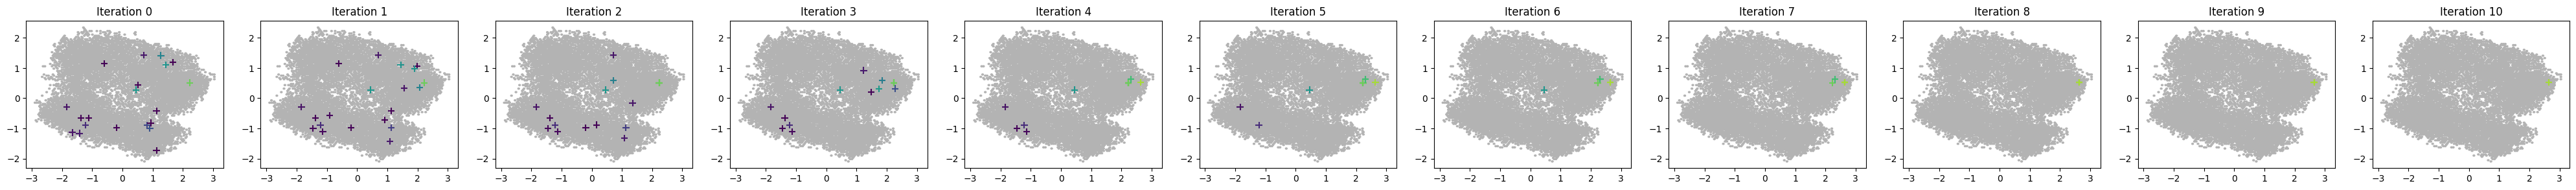

In [ ]:
# Generaing a figure to show how the particles in EPSO move around
fig, ax = plt.subplots(1, (num_iterations + 1), figsize=(40, 40))
fig.tight_layout()
print(all_positions)


for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(y.shape[0]), cmap="binary", vmin=0, vmax=1)

for i in range( (num_iterations + 1) ):

    ids_acquired = []
    for id in all_positions:
        if i < len(id):
            ids_acquired.append(id[i])

    print(ids_acquired)
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('Iteration {}'.format(i))

#plt.savefig("iterations_!.pdf", bbox_inches="tight")
plt.show()


50


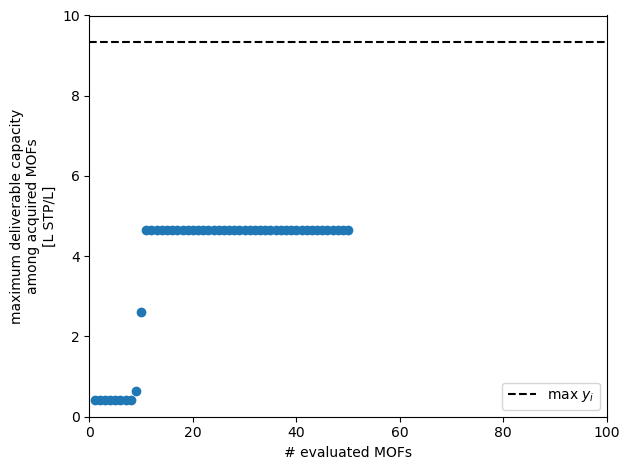

In [8]:
# A scatter plot for a simple EPSO run
x_values = np.arange(1, len(global_max_per_function_call) + 1)

print(len(global_max_per_function_call))

plt.figure()
plt.scatter(x_values, global_max_per_function_call)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
#plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [3]:
# Running EPSO many times to generate averages
# We will also measure the time taken for each of the optimization techniques to run!
import time

num_particles = 20
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w = 2.0
c1 = 1.0
c2 = 1.0
num_iterations = 10

nb_runs = 50  # Number of runs of this we're doing!

gmpfc_arr = []
apt_arr = []
time_elapsed_per_run = []

for run_no in range(nb_runs):
    print("Run # ", run_no)

    start_time = time.time()

    initial_positions_PSO = random.choices(X, k=num_particles)
    #print("Initial Position for Run No. ", run_no, ": ", initial_positions_PSO)

    pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c1, c2, num_iterations, initial_positions_PSO)
    best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Run # ",  run_no, " completed in ", elapsed_time, " seconds!")
    time_elapsed_per_run.append(elapsed_time)

    print("best_fitness for Run No. ", run_no, ": ", best_fitness)
    gmpfc_arr.append(global_max_per_function_call)
    apt_arr.append(all_function_calls)

print(gmpfc_arr)
print(apt_arr)
print(time_elapsed_per_run)

# Dumping this data into a .pkl file
with open('epso_graph_results.pkl', 'wb') as file:
  pickle.dump({'gmpfc_arr': gmpfc_arr, 'apt_arr': apt_arr, 'time_elapsed_per_run': time_elapsed_per_run}, file)

Run #  0
Run #  0  completed in  32.73977708816528  seconds!
best_fitness for Run No.  0 :  4.853515224
Run #  1
Run #  1  completed in  39.76489973068237  seconds!
best_fitness for Run No.  1 :  5.417302526
Run #  2
Run #  2  completed in  41.53501892089844  seconds!
best_fitness for Run No.  2 :  7.421343448
Run #  3
Run #  3  completed in  35.01251029968262  seconds!
best_fitness for Run No.  3 :  7.828555987
Run #  4
Run #  4  completed in  38.44862151145935  seconds!
best_fitness for Run No.  4 :  5.881718464
Run #  5
Run #  5  completed in  39.88801980018616  seconds!
best_fitness for Run No.  5 :  6.985037524
Run #  6
Run #  6  completed in  33.62904214859009  seconds!
best_fitness for Run No.  6 :  5.812727727
Run #  7
Run #  7  completed in  37.133920669555664  seconds!
best_fitness for Run No.  7 :  6.93343689
Run #  8
Run #  8  completed in  35.74600696563721  seconds!
best_fitness for Run No.  8 :  4.566463887
Run #  9
Run #  9  completed in  31.837438583374023  seconds!
be

In [ ]:
# Dumping this data into a .pkl file
with open('epso_graph_results.pkl', 'wb') as file:
  pickle.dump({'gmpfc_arr': gmpfc_arr, 'apt_arr': apt_arr, 'time_elapsed_per_run': time_elapsed_per_run}, file)

In [ ]:
# Extracting the run with maximum number of unique function calls:
num_iterations_per_run = []
for i in range(len(gmpfc_arr)):
    num_iterations_per_run.append(len(gmpfc_arr[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[31, 56, 56, 42, 51, 64, 46, 55, 48, 53, 59, 39, 44, 47, 46, 42, 66, 43, 48, 57, 59, 56, 47, 54, 45, 44, 59, 60, 42, 57, 41, 38, 50, 54, 52, 56, 65, 43, 67, 52, 48, 41, 57, 53, 42, 48, 44, 51, 69, 50]
69


In [ ]:
# Calculating these values! (See Visualizations.ipynb for more info)
y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(max_num_iterations):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes.append(gmpfc_arr[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [1.941073102, 0.403351668, 0.460483609, 2.857845533, 1.143884198, 4.462672484, 0.015156501, 0.54668532, 0.08401475, 0.452125914, 0.128597396, 0.079727333, 0.543741706, 4.15609018, 0.16082419, 0.207917251, 0.359850363, 0.471588292, 0.064329395, 0.359591497, 0.045436721, 0.070046436, 0.004425434, 0.451635286, 0.00768864, 0.357331697, 0.084517009, 2.753697611, 0.536782438, 0.058805306, 2.818234584, 0.026605237, 0.04799987, 0.593776626, 7.379416923, 0.004502113, 0.031145335, 0.540776671, 0.048869166, 3.194619752, 0.370076021, 0.535303319, 0.225769509, 0.509984998, 2.838203351, 2.981895457, 0.351947988, 0.038381098, 0.228122356, 3.418111701]
y_max_mu[i]:  0.9890731867
y_maxes < y_max_mu[i]:  [False  True  True False False False  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True False  True  True  True False  True
  True  True  True False  True  True  True  True False Fa

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
np_y_max_mu = np.array(y_max_mu)
np_y_max_sig_bot = np.array(y_max_sig_bot)
np_y_max_sig_top = np.array(y_max_sig_top)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]


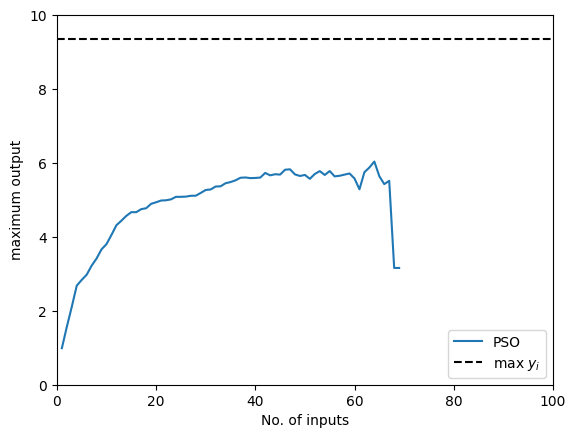

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu - np_y_max_sig_bot, np_y_max_mu + np_y_max_sig_top, alpha=0.2, ec="None")

plt.xlabel('No. of inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
with open('epso_graph_outputs.pkl', 'wb') as file:
    pickle.dump({'y_max_mu_epso': y_max_mu, 'y_max_sig_bot_epso': y_max_sig_bot, 'y_max_sig_top_epso': y_max_sig_top}, file)

In [ ]:
ids_to_rank = np.argsort(y.squeeze())
print(ids_to_rank)

[22796 22084 22974 ... 20581  7486 21275]


In [ ]:
top_100_COF_ids = np.flip(np.argsort(y))[:100]
assert np.size(top_100_COF_ids) == 100
print("top 100 COFs range from y =", np.min(y[top_100_COF_ids]), "to", np.max(y[top_100_COF_ids]))

top 100 COFs range from y = 7.371122512 to 9.55440106


In [ ]:
def fraction_in_top100_cofs(ids_acquired):
    nb_in_top_100 = 0
    for id_acquired in ids_acquired:
        if id_acquired in top_100_COF_ids:
            nb_in_top_100 += 1
    return nb_in_top_100 / 100

In [ ]:
# get fraction of aquired MOFs in top 100 for EPSO
def y_top_100(arr):
    y_top100_mu      = np.zeros(max_num_iterations)

    for i in range(max_num_iterations):
        y_ranks = []

        for j in range(nb_runs):
            temp = []
            if ( i < len(arr[j]) ): #only if arr[] has ith function call!
                for k in range(i):
                    temp.append(arr[j][k])
            else:
                temp = arr[j]

            y_ranks.append(temp)

        y_frac_top_100_per_run = []
        for l in y_ranks:
            y_frac_top_100_per_run.append(fraction_in_top100_cofs(l))


        np_y_frac_top_100_per_run = np.array(y_frac_top_100_per_run)

        y_top100_mu[i] = np.mean(np_y_frac_top_100_per_run)


    return y_top100_mu


y_top100_mu_epso = y_top_100(apt_arr)
print(y_top100_mu_epso)


[0.     0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0004 0.0004
 0.0004 0.0006 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008
 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008 0.0008
 0.0008 0.0008 0.0008 0.0008 0.001  0.001  0.001  0.001  0.001  0.001
 0.001  0.001  0.0014 0.0014 0.0014 0.0014 0.0016 0.0016 0.0016 0.0018
 0.002  0.0022 0.0026 0.0028 0.003  0.0032 0.0034 0.0034 0.0038 0.004
 0.004  0.004  0.004  0.0042 0.0042 0.0042 0.0042 0.0042 0.0042]


In [ ]:
# We're going to "fix" the non-monotonicity of the PSO graph now, by adding dummy samples
gmpfc_arr_fixed = (pickle.load ( open ( 'epso_graph_results.pkl', 'rb' ) ) [ 'gmpfc_arr' ] )
apt_arr_fixed = (pickle.load(open('epso_graph_results.pkl', 'rb'))['apt_arr'])

In [ ]:
print(len(gmpfc_arr_fixed))

50


In [ ]:
num_iterations_per_run = []
for i in range(50):
    num_iterations_per_run.append(len(gmpfc_arr_fixed[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[31, 56, 56, 42, 51, 64, 46, 55, 48, 53, 59, 39, 44, 47, 46, 42, 66, 43, 48, 57, 59, 56, 47, 54, 45, 44, 59, 60, 42, 57, 41, 38, 50, 54, 52, 56, 65, 43, 67, 52, 48, 41, 57, 53, 42, 48, 44, 51, 69, 50]
69


In [ ]:
for i in range(39):
    if (len(gmpfc_arr_fixed[i]) < max_num_iterations):
        for j in range(max_num_iterations - len(gmpfc_arr_fixed[i])):
            gmpfc_arr_fixed[i].append(gmpfc_arr_fixed[i][len(gmpfc_arr_fixed[i]) - 1])

In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu_fixed = []
y_max_sig_bot_fixed = []
y_max_sig_top_fixed = []

for i in range(max_num_iterations):
    y_maxes_fixed = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr_fixed[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes_fixed.append(gmpfc_arr_fixed[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes_fixed)
    y_max_mu_fixed.append( np.mean(y_maxes_fixed) )
    print("y_max_mu_fixed[i]: ", y_max_mu_fixed[i])
    print("y_maxes_fixed < y_max_mu_fixed[i]: ", y_maxes_fixed < y_max_mu_fixed[i])

    y_maxes_L_y_max_mu_i_fixed = y_maxes_fixed < y_max_mu_fixed[i]
    y_max_sig_bot_temp_fixed = []
    for k in range(len(y_maxes_L_y_max_mu_i_fixed)):
        if (y_maxes_L_y_max_mu_i_fixed[k] == True):
            y_max_sig_bot_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_bot_fixed.append( np.std ( y_max_sig_bot_temp_fixed )  )
    print(y_max_sig_bot_fixed[i])

    y_maxes_G_y_max_mu_i_fixed = y_maxes_fixed > y_max_mu_fixed[i]
    y_max_sig_top_temp_fixed = []
    for k in range(len(y_maxes_G_y_max_mu_i_fixed)):
        if (y_maxes_G_y_max_mu_i_fixed[k] == True):
            y_max_sig_top_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_top_fixed.append( np.std ( y_max_sig_top_temp_fixed )  )
    print(y_max_sig_top_fixed[i])

print("y_max_mu_fixed: ", y_max_mu_fixed)
print("y_max_sig_bot_fixed: ", y_max_sig_bot_fixed)
print("y_max_sig_top_fixed: ", y_max_sig_top_fixed)


y_maxes for iteration  0 :  [1.941073102, 0.403351668, 0.460483609, 2.857845533, 1.143884198, 4.462672484, 0.015156501, 0.54668532, 0.08401475, 0.452125914, 0.128597396, 0.079727333, 0.543741706, 4.15609018, 0.16082419, 0.207917251, 0.359850363, 0.471588292, 0.064329395, 0.359591497, 0.045436721, 0.070046436, 0.004425434, 0.451635286, 0.00768864, 0.357331697, 0.084517009, 2.753697611, 0.536782438, 0.058805306, 2.818234584, 0.026605237, 0.04799987, 0.593776626, 7.379416923, 0.004502113, 0.031145335, 0.540776671, 0.048869166, 3.194619752, 0.370076021, 0.535303319, 0.225769509, 0.509984998, 2.838203351, 2.981895457, 0.351947988, 0.038381098, 0.228122356, 3.418111701]
y_max_mu_fixed[i]:  0.9890731867
y_maxes_fixed < y_max_mu_fixed[i]:  [False  True  True False False False  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True False  True  True  True False  True
  True  True  True False  True  True  T

In [ ]:
np_y_max_mu_fixed = np.array(y_max_mu_fixed)
np_y_max_sig_bot_fixed = np.array(y_max_sig_bot_fixed)
np_y_max_sig_top_fixed = np.array(y_max_sig_top_fixed)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]


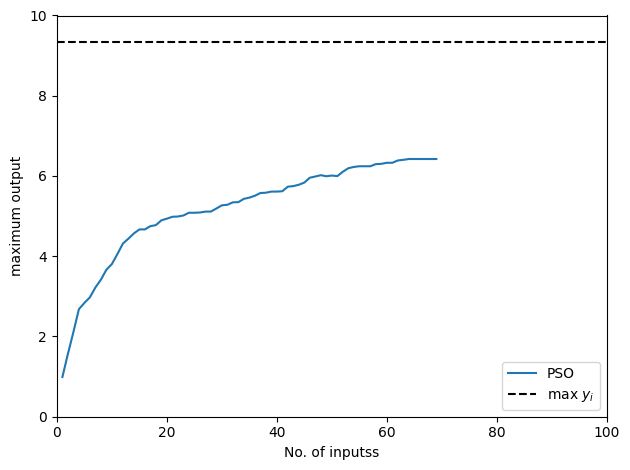

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu_fixed, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu_fixed - np_y_max_sig_bot_fixed, np_y_max_mu_fixed + np_y_max_sig_top_fixed, alpha=0.2, ec="None")

plt.xlabel('No. of inputss')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run_fixed.pdf")
plt.show()

In [ ]:
# Dumping fixed output values
with open('epso_graph_outputs_fixed.pkl', 'wb') as file:
    pickle.dump({'y_max_mu_epso_fixed': y_max_mu_fixed, 'y_max_sig_bot_epso_fixed': y_max_sig_bot_fixed, 'y_max_sig_top_epso_fixed': y_max_sig_top_fixed}, file)

In [ ]:
# Modifying EPSO with a new velocity profile:

def objective_function(x):
    x = np.array(x)

    # Finding the closest data point in the dataset
    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    return y[closest_index]

# snap_position essentially snaps the input to the point in the database closest to it
def snap_position(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)

    snapped_input = X[closest_index]
    return snapped_input

# returns the index in the database closest to the input given to the method
def closest_index(x):
    x = np.array(x)

    distances = np.sum((X - x)**2, axis=1)
    closest_index = np.argmin(distances)
    return closest_index

# See Evolutionary_Graph_PSO for the working of EPSO
class Particle:
    def __init__(self, num_dimensions, init_position, index):
        self.position = init_position
        self.velocity = np.zeros(num_dimensions)
        self.best_position = np.copy(self.position)
        self.best_fitness = objective_function(self.position)
        self.index = index
        # This array is keeps track of all of the inputs in the database that the particle has visited. useful for generating plots later
        self.positions_traversed = [closest_index(init_position)]

class PSO:
    def __init__(self, num_particles, num_dimensions, lower_bound, upper_bound, w, c, num_iterations, init_positions):
        self.num_particles = num_particles
        self.num_dimensions = num_dimensions
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.w = w
        self.c = c
        self.num_iterations = num_iterations
        self.particles = [Particle(num_dimensions, init_positions[ind], ind) for ind in range(num_particles)]
        self.global_best_position = np.copy(self.particles[0].position)
        self.global_best_fitness = self.particles[0].best_fitness
        # These arrays are used to generate some useful information used to plot graphs later
        self.unique_function_call_ids = []
        self.global_max_for_each_unique_function_call = []

        init_pos_max = -1.0
        init_position_max = np.copy(self.particles[0].position)
        for init_pos in init_positions:
            self.unique_function_call_ids.append(closest_index(init_pos))
            if (y[closest_index(init_pos)] > init_pos_max):
                init_position_max = np.copy(init_pos)
                init_pos_max = y[closest_index(init_pos)]
            self.global_max_for_each_unique_function_call.append(init_pos_max)

        self.global_best_position = np.copy(init_position_max)
        self.global_best_fitness = init_pos_max

    def update_particles(self):

        velocity_weights = []
        best_positions = []
        # Computing the new velocitiy profile
        for particle in self.particles:
            velocity_weights.append(particle.best_fitness)
            best_positions.append(particle.best_position)

        for particle in self.particles:
            # Update velocities
            particle.velocity = self.w * particle.velocity
            for i in range(len(velocity_weights)):
                particle.velocity = particle.velocity + ((self.c * velocity_weights[i]) * (best_positions[i] - particle.position))

            if(np.linalg.norm(particle.velocity) > 1.5):
                print("old norm: ", np.linalg.norm(particle.velocity))
                particle.velocity = ((particle.velocity / np.linalg.norm(particle.velocity)) * 1.5)
                print("new norm: ", np.linalg.norm(particle.velocity))

            particle.position = particle.position + particle.velocity

            particle.position = np.clip(particle.position, self.lower_bound, self.upper_bound)
            particle.position = snap_position(particle.position)

            particle.positions_traversed.append(closest_index(particle.position))


    def update_personal_and_global_bests(self):
        for particle in self.particles:
            unique_function_called = False
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
                unique_function_called = True

            current_fitness = objective_function(particle.position)

            if current_fitness > particle.best_fitness:
                particle.best_position = np.copy(particle.position)
                particle.best_fitness = current_fitness

                if current_fitness > self.global_best_fitness:
                    self.global_best_position = np.copy(particle.position)
                    self.global_best_fitness = current_fitness

            if (unique_function_called == True):
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

    def eliminate(self):
        num_to_eliminate = int((self.num_particles / (self.num_iterations - 1)))
        if not self.particles:
            return []

        for _ in range(num_to_eliminate):
            min_index = 0
            for j in range(1, len(self.particles)):
                if (input_index(snap_position(self.particles[j].position)) < input_index(snap_position(self.particles[min_index].position))):
                    min_index = j
            self.particles.pop(min_index)

    def optimize(self):
        all_positions_traversed = []
        for i in range(self.num_particles):
            all_positions_traversed.append([0.0])

        for particle in self.particles:
            if closest_index(particle.position) not in self.unique_function_call_ids:
                self.unique_function_call_ids.append(closest_index(particle.position))
            if particle.best_fitness > self.global_best_fitness:
                self.global_best_position = np.copy(particle.position)
                self.global_best_fitness = particle.best_fitness
                self.global_max_for_each_unique_function_call.append(self.global_best_fitness)

        for i in range(self.num_iterations):
            self.update_particles()
            self.update_personal_and_global_bests()
            for j in range(self.num_particles):
                for k in self.particles:
                    if(j == k.index):
                        all_positions_traversed[j] = k.positions_traversed


            if (i != (self.num_iterations - 1)):
                self.eliminate()

        return self.global_best_position, self.global_best_fitness, all_positions_traversed, self.unique_function_call_ids, self.global_max_for_each_unique_function_call


In [ ]:
# Running EPSO once
num_particles = 20
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w = 2.0
c = 1.0
num_iterations = 10


initial_positions_PSO = random.choices(X, k=num_particles)
print(initial_positions_PSO)

pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c, num_iterations, initial_positions_PSO)
best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()

print("Best position found: ", best_position)
print("Best fitness found: ", best_fitness)
print("All_positions: ", all_positions)
print("All_function_calls: ", all_function_calls)
print("Global_max_per_function_call: ", global_max_per_function_call)

[array([1.00000000e+00, 8.09815475e-04, 1.07993033e-01, 9.37224699e-02,
       0.00000000e+00, 2.25584410e-03, 5.00000000e-01, 5.88724107e-01,
       6.20978261e-01, 6.49856991e-01, 6.60174873e-01, 6.66928187e-01,
       1.41935484e-01, 3.33333333e-01, 1.80973783e-01, 4.19354839e-01,
       8.60215054e-02, 8.60215054e-02, 7.62666667e-01, 9.38144330e-01,
       4.85801170e-01, 9.10891089e-01, 1.00000000e-02, 9.20000000e-01,
       1.23527385e-01, 2.97234390e-01, 1.60461725e-01, 3.71271637e-01,
       7.40372471e-02, 7.40372471e-02, 1.25811479e-01, 5.59072090e-01,
       3.50959857e-01, 5.69439668e-01, 1.03675778e-02, 1.03675778e-02,
       7.29411765e-01, 9.41176471e-01, 6.60000000e-01, 9.41176471e-01,
       0.00000000e+00, 9.41176471e-01, 2.66666667e-01, 5.00000000e-01,
       3.30000000e-01, 6.66666667e-01, 1.66666667e-01, 1.66666667e-01,
       2.60093897e-01, 5.53990610e-01, 4.04882629e-01, 6.76056338e-01,
       1.22065728e-01, 1.22065728e-01, 7.76384535e-01, 9.56112853e-01,
     

41


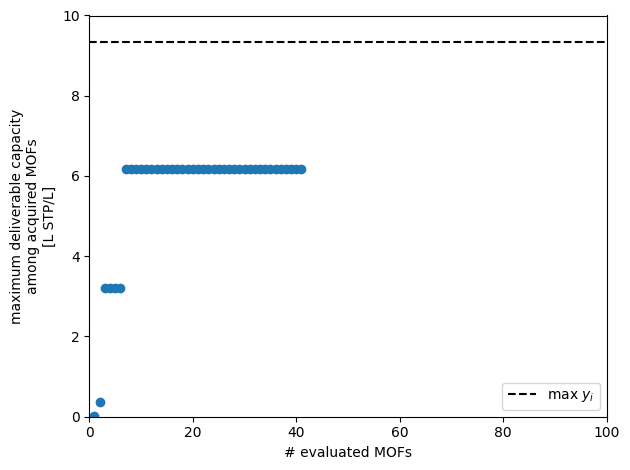

In [ ]:
# A scatter plot for a simple EPSO run
x_values = np.arange(1, len(global_max_per_function_call) + 1)

print(len(global_max_per_function_call))

plt.figure()
plt.scatter(x_values, global_max_per_function_call)
plt.xlabel('# evaluated MOFs')
plt.ylabel('maximum deliverable capacity\namong acquired MOFs\n[L STP/L]')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
# Running EPSO many times to generate averages

num_particles = 20
num_dimensions = 151
lower_bound = 0
upper_bound = 1.0
w = 2.0
c = 1.0
num_iterations = 10

nb_runs = 50  # Number of runs of this we're doing!

gmpfc_arr = []
apt_arr = []

for run_no in range(nb_runs):
    print("Run No.: ", run_no)
    initial_positions_PSO = random.choices(X, k=num_particles)
    print("Initial Position for Run No. ", run_no, ": ", initial_positions_PSO)
    pso = PSO(num_particles, num_dimensions, lower_bound, upper_bound, w, c, num_iterations, initial_positions_PSO)
    best_position, best_fitness, all_positions, all_function_calls, global_max_per_function_call = pso.optimize()
    print("best_fitness for Run No. ", run_no, ": ", best_fitness)
    gmpfc_arr.append(global_max_per_function_call)
    apt_arr.append(all_function_calls)

print(gmpfc_arr)
print(apt_arr)

Streaming output truncated to the last 5000 lines.
       2.14285714e-01, 2.14285714e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.50000000e-01, 2.00000000e-01, 1.50000000e-01, 2.00000000e-01,
       0.00000000e+00, 2.00000000e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.84615385e-02, 1.53846154e-01, 1.15384615e-01, 1.53846154e-01,
       0.00000000e+00, 0.00000000e+00, 5.68181818e-02, 4.54545455e-02,
       3.40909091e-02, 9.09090909e-02, 4.54545455e-02, 4.54545455e-02,
       8.43303065e-02, 1.89580023e-01, 1.42185017e-01, 2.26515323e-01,
       3.69353008e-02, 3.69353008e-02, 1.88144658e-01, 2.50859544e-01,
       1.88144658e-01, 2.50859544e-01, 0.00000000e+00, 2.50859544e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.54405286e-01, 7.88546256e-01,
       5.91409692e-01, 8.4

In [ ]:
# Extracting the run with maximum number of unique function calls:
num_iterations_per_run = []
for i in range(len(gmpfc_arr)):
    num_iterations_per_run.append(len(gmpfc_arr[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[52, 60, 54, 45, 55, 42, 38, 55, 59, 54, 46, 58, 48, 53, 55, 58, 57, 42, 55, 52, 52, 51, 60, 45, 54, 47, 47, 56, 55, 51, 53, 56, 43, 56, 49, 63, 55, 50, 56, 48, 50, 52, 56, 51, 51, 54, 55, 56, 56, 46]
63


In [ ]:
# Calculating these values! (See Visualizations.ipynb for more info)
y_max_mu = []
y_max_sig_bot = []
y_max_sig_top = []

for i in range(max_num_iterations):
    y_maxes = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes.append(gmpfc_arr[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes)
    y_max_mu.append( np.mean(y_maxes) )
    print("y_max_mu[i]: ", y_max_mu[i])
    print("y_maxes < y_max_mu[i]: ", y_maxes < y_max_mu[i])

    y_maxes_L_y_max_mu_i = y_maxes < y_max_mu[i]
    y_max_sig_bot_temp = []
    for k in range(len(y_maxes_L_y_max_mu_i)):
        if (y_maxes_L_y_max_mu_i[k] == True):
            y_max_sig_bot_temp.append(y_maxes[k])
    y_max_sig_bot.append( np.std ( y_max_sig_bot_temp )  )
    print(y_max_sig_bot[i])

    y_maxes_G_y_max_mu_i = y_maxes > y_max_mu[i]
    y_max_sig_top_temp = []
    for k in range(len(y_maxes_G_y_max_mu_i)):
        if (y_maxes_G_y_max_mu_i[k] == True):
            y_max_sig_top_temp.append(y_maxes[k])
    y_max_sig_top.append( np.std ( y_max_sig_top_temp )  )
    print(y_max_sig_top[i])

print("y_max_mu: ", y_max_mu)
print("y_max_sig_bot: ", y_max_sig_bot)
print("y_max_sig_top: ", y_max_sig_top)


y_maxes for iteration  0 :  [0.566075364, 0.061723118, 0.083897366, 0.028676009, 0.182346211, 0.614177532, 2.520805798, 0.072903472, 0.427412782, 0.119283339, 0.237220366, 0.566559093, 1.853291144, 0.335461125, 1.091863399, 0.178269716, 0.130571015, 0.604049646, 6.736917931, 0.414751654, 4.574993706, 0.102179575, 0.562820415, 0.018562618, 0.338412427, 1.397483728, 2.476012474, 0.631622156, 0.012638362, 0.008797188, 0.557543467, 0.11109318, 0.625487353, 0.048336079, 0.013363453, 1.754261221, 0.135343517, 4.517530279, 0.025755494, 2.59309733, 0.705884065, 0.035373225, 0.141059697, 0.424117704, 0.179728431, 0.004662295, 0.006439509, 0.175722298, 0.057756806, 2.377275656]
y_max_mu[i]:  0.82879219576
y_maxes < y_max_mu[i]:  [ True  True  True  True  True  True False  True  True  True  True  True
 False  True False  True  True  True False  True False  True  True  True
  True False False  True  True  True  True  True  True  True  True False
  True False  True False  True  True  True  True  Tr

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
np_y_max_mu = np.array(y_max_mu)
np_y_max_sig_bot = np.array(y_max_sig_bot)
np_y_max_sig_top = np.array(y_max_sig_top)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


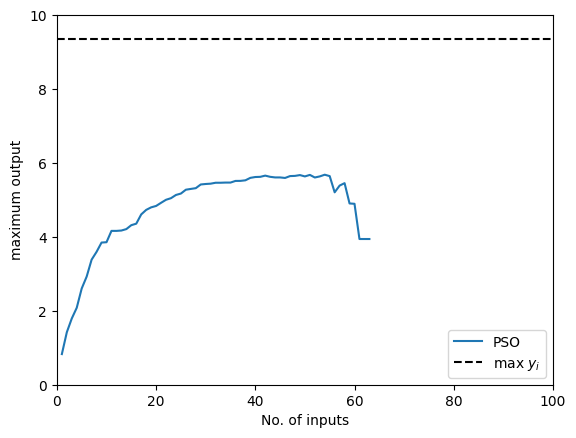

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu, label="PSO", clip_on=False)
plt.fill_between(max_num_iterations, np_y_max_mu - np_y_max_sig_bot, np_y_max_mu + np_y_max_sig_top, alpha=0.2, ec="None")

plt.xlabel('No. of inputs')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.savefig("search_efficiency_for_specific_acquisition_run.pdf")
plt.show()

In [ ]:
with open('epso_vel_outputs.pkl', 'wb') as file:
    pickle.dump({'y_max_mu_epso': y_max_mu, 'y_max_sig_bot_epso': y_max_sig_bot, 'y_max_sig_top_epso': y_max_sig_top}, file)

In [ ]:
# We're going to "fix" the non-monotonicity of the PSO graph now, by adding dummy samples
gmpfc_arr_fixed = gmpfc_arr
apt_arr_fixed = apt_arr

In [ ]:
num_iterations_per_run = []
for i in range(50):
    num_iterations_per_run.append(len(gmpfc_arr_fixed[i]))

print(num_iterations_per_run)
max_num_iterations = np.max(num_iterations_per_run)
print(max_num_iterations)

[52, 60, 54, 45, 55, 42, 38, 55, 59, 54, 46, 58, 48, 53, 55, 58, 57, 42, 55, 52, 52, 51, 60, 45, 54, 47, 47, 56, 55, 51, 53, 56, 43, 56, 49, 63, 55, 50, 56, 48, 50, 52, 56, 51, 51, 54, 55, 56, 56, 46]
63


In [ ]:
for i in range(39):
    if (len(gmpfc_arr_fixed[i]) < max_num_iterations):
        for j in range(max_num_iterations - len(gmpfc_arr_fixed[i])):
            gmpfc_arr_fixed[i].append(gmpfc_arr_fixed[i][len(gmpfc_arr_fixed[i]) - 1])

In [ ]:
# Generating the arrays we will use to plot our final figures:

y_max_mu_fixed = []
y_max_sig_bot_fixed = []
y_max_sig_top_fixed = []

for i in range(max_num_iterations):
    y_maxes_fixed = []
    for j in range(nb_runs):
          if( i < len(gmpfc_arr_fixed[j]) ): #only if gmpfc_arr[j] has ith iteration!
              y_maxes_fixed.append(gmpfc_arr_fixed[j][i])

    print("y_maxes for iteration ", i, ": ", y_maxes_fixed)
    y_max_mu_fixed.append( np.mean(y_maxes_fixed) )
    print("y_max_mu_fixed[i]: ", y_max_mu_fixed[i])
    print("y_maxes_fixed < y_max_mu_fixed[i]: ", y_maxes_fixed < y_max_mu_fixed[i])

    y_maxes_L_y_max_mu_i_fixed = y_maxes_fixed < y_max_mu_fixed[i]
    y_max_sig_bot_temp_fixed = []
    for k in range(len(y_maxes_L_y_max_mu_i_fixed)):
        if (y_maxes_L_y_max_mu_i_fixed[k] == True):
            y_max_sig_bot_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_bot_fixed.append( np.std ( y_max_sig_bot_temp_fixed )  )
    print(y_max_sig_bot_fixed[i])

    y_maxes_G_y_max_mu_i_fixed = y_maxes_fixed > y_max_mu_fixed[i]
    y_max_sig_top_temp_fixed = []
    for k in range(len(y_maxes_G_y_max_mu_i_fixed)):
        if (y_maxes_G_y_max_mu_i_fixed[k] == True):
            y_max_sig_top_temp_fixed.append(y_maxes_fixed[k])
    y_max_sig_top_fixed.append( np.std ( y_max_sig_top_temp_fixed )  )
    print(y_max_sig_top_fixed[i])

print("y_max_mu_fixed: ", y_max_mu_fixed)
print("y_max_sig_bot_fixed: ", y_max_sig_bot_fixed)
print("y_max_sig_top_fixed: ", y_max_sig_top_fixed)


y_maxes for iteration  0 :  [0.566075364, 0.061723118, 0.083897366, 0.028676009, 0.182346211, 0.614177532, 2.520805798, 0.072903472, 0.427412782, 0.119283339, 0.237220366, 0.566559093, 1.853291144, 0.335461125, 1.091863399, 0.178269716, 0.130571015, 0.604049646, 6.736917931, 0.414751654, 4.574993706, 0.102179575, 0.562820415, 0.018562618, 0.338412427, 1.397483728, 2.476012474, 0.631622156, 0.012638362, 0.008797188, 0.557543467, 0.11109318, 0.625487353, 0.048336079, 0.013363453, 1.754261221, 0.135343517, 4.517530279, 0.025755494, 2.59309733, 0.705884065, 0.035373225, 0.141059697, 0.424117704, 0.179728431, 0.004662295, 0.006439509, 0.175722298, 0.057756806, 2.377275656]
y_max_mu_fixed[i]:  0.82879219576
y_maxes_fixed < y_max_mu_fixed[i]:  [ True  True  True  True  True  True False  True  True  True  True  True
 False  True False  True  True  True False  True False  True  True  True
  True False False  True  True  True  True  True  True  True  True False
  True False  True False  True  Tr

In [ ]:
np_y_max_mu_fixed = np.array(y_max_mu_fixed)
np_y_max_sig_bot_fixed = np.array(y_max_sig_bot_fixed)
np_y_max_sig_top_fixed = np.array(y_max_sig_top_fixed)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


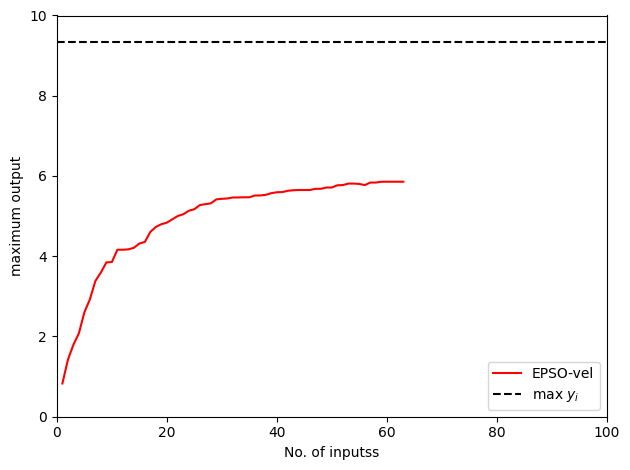

In [ ]:
x_values = np.arange(1, max_num_iterations + 1)
print(x_values)

plt.figure()
plt.plot(x_values, y_max_mu_fixed, label="EPSO-vel", clip_on=False, color="red")
plt.fill_between(max_num_iterations, np_y_max_mu_fixed - np_y_max_sig_bot_fixed, np_y_max_mu_fixed + np_y_max_sig_top_fixed, alpha=0.2, ec="None")

plt.xlabel('No. of inputss')
plt.ylabel('maximum output')

plt.axhline(y=9.35, color="k", linestyle="--", label="$\max$ $y_i$", zorder=0)
plt.xlim([0, 100])
plt.ylim([0, 10])
plt.legend()

plt.tight_layout()
plt.savefig("search_efficiency_for_specific_acquisition_run_fixed.pdf")
plt.show()